<a href="https://colab.research.google.com/github/willystw/fastai-learning/blob/hr-analytics/hr-analytics/HR_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving [HR Analytics Job Change](https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists) using Neural Network and Google Colab

In [2]:
#hide
!pip install -Uqq fastbook kaggle
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 1.2 MB 7.0 MB/s 
     |████████████████████████████████| 186 kB 37.2 MB/s 
     |████████████████████████████████| 46 kB 5.3 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
     |████████████████████████████████| 51 kB 402 kB/s 
Mounted at /content/gdrive


Insert kaggle.json before proceed to the next step

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [113]:
#hide
from fastbook import *
from kaggle import api
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

In [5]:
!rm -r ~/hr-analytics
!mkdir ~/hr-analytics

rm: cannot remove '/root/hr-analytics': No such file or directory


In [6]:
#Download dataset
api.dataset_download_cli(dataset='arashnic/hr-analytics-job-change-of-data-scientists',
                         path='hr-analytics',
                         unzip=True,
                         force=True)

100%|██████████| 295k/295k [00:00<00:00, 2.82MB/s]

In [7]:
train_ds = pd.read_csv('hr-analytics/aug_train.csv', low_memory=False)
test_ds = pd.read_csv('hr-analytics/aug_test.csv')

In [8]:
train_ds.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [9]:
dep_var = 'target'

## Baseline

In [11]:
train_ds[dep_var].value_counts()

0.0    14381
1.0     4777
Name: target, dtype: int64

What is the probability if I return false in every training data ? This data will be used as baseline

In [12]:
14381 / (14381 +  4777)

0.7506524689424784

This means 75% of accuracy

## Using Neural Network

In [148]:
cont,cat = cont_cat_split(train_ds, max_card=2000, dep_var=dep_var)
cont, cat

(['enrollee_id', 'city_development_index'],
 ['city',
  'gender',
  'relevent_experience',
  'enrolled_university',
  'education_level',
  'major_discipline',
  'experience',
  'company_size',
  'company_type',
  'last_new_job',
  'training_hours'])

In [14]:
procs = [Categorify, FillMissing, Normalize]
tabular_data = TabularPandas(train_ds, 
                      procs, 
                      cat, 
                      cont,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_ds)), 
                      y_names=dep_var,
                      y_block = CategoryBlock )

In [15]:
dls = tabular_data.dataloaders(512)
dls.show_batch()

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,enrollee_id,city_development_index,target
0,city_67,Male,Has relevent experience,no_enrollment,#na#,#na#,>20,5000-9999,Public Sector,>4,17,10930.000178,0.855,0.0
1,city_136,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,#na#,1,9,26745.000566,0.897,0.0
2,city_16,#na#,Has relevent experience,no_enrollment,Graduate,STEM,>20,10/49,Pvt Ltd,>4,282,7099.000463,0.910,0.0
3,city_21,Male,Has relevent experience,Full time course,Masters,STEM,1,50-99,Pvt Ltd,1,22,18506.000031,0.624,0.0
4,city_21,Male,Has relevent experience,no_enrollment,Graduate,STEM,6,<10,Funded Startup,1,88,21691.999776,0.624,0.0
5,city_103,#na#,No relevent experience,Full time course,Graduate,STEM,7,#na#,#na#,#na#,47,20226.000143,0.920,0.0
6,city_21,Male,No relevent experience,Full time course,Graduate,STEM,<1,#na#,#na#,never,64,33287.000082,0.624,1.0
7,city_136,#na#,Has relevent experience,no_enrollment,Masters,STEM,4,5000-9999,Public Sector,1,130,15748.999965,0.897,0.0
8,city_16,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,50-99,Pvt Ltd,1,70,19219.000013,0.910,0.0
9,city_70,Male,No relevent experience,no_enrollment,Graduate,STEM,6,#na#,#na#,never,23,8542.999991,0.698,1.0


SuggestedLRs(valley=0.0005754399462603033)

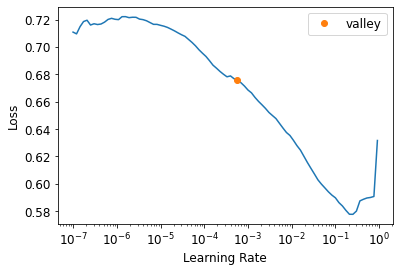

In [32]:
learn = tabular_learner(dls,
                        metrics=[accuracy, RocAucBinary()])
learn.lr_find()

In [27]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.524940,0.466519,0.772383,0.777494,00:00
1,0.465548,0.447390,0.778126,0.776347,00:00


SuggestedLRs(valley=0.0002290867705596611)

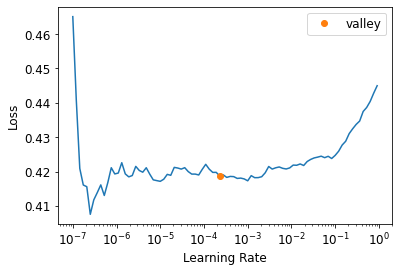

In [28]:
learn.lr_find()

In [29]:
learn.fit_one_cycle(5, 1e-4, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.418658,0.447368,0.785957,0.776938,00:00
1,0.418027,0.448509,0.791960,0.777754,00:00
2,0.418415,0.448245,0.789872,0.778004,00:00
3,0.417776,0.448514,0.791699,0.778142,00:00
4,0.417501,0.448459,0.791438,0.778083,00:00


## Possible Improvement

In [114]:
def rf(xs, y, n_estimators=40, max_samples=10_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [115]:
m = rf(xs, y);

In [116]:
xs,y = tabular_data.train.xs,tabular_data.train.y
valid_xs,valid_y = tabular_data.valid.xs,tabular_data.valid.y

In [117]:
roc_auc_score(y.to_numpy(), m.predict(xs)), roc_auc_score(valid_y.to_numpy(), m.predict(valid_xs))

(0.9420476586955895, 0.7832312663162277)

In [119]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [125]:
fi = rf_feat_importance(m, xs)
fi[:13]

,cols,imp
12,city_development_index,0.268210
11,enrollee_id,0.138084
10,training_hours,0.114303
7,company_size,0.105771
0,city,0.080692
6,experience,0.076846
8,company_type,0.051002
9,last_new_job,0.042479
5,major_discipline,0.035986
4,education_level,0.025621


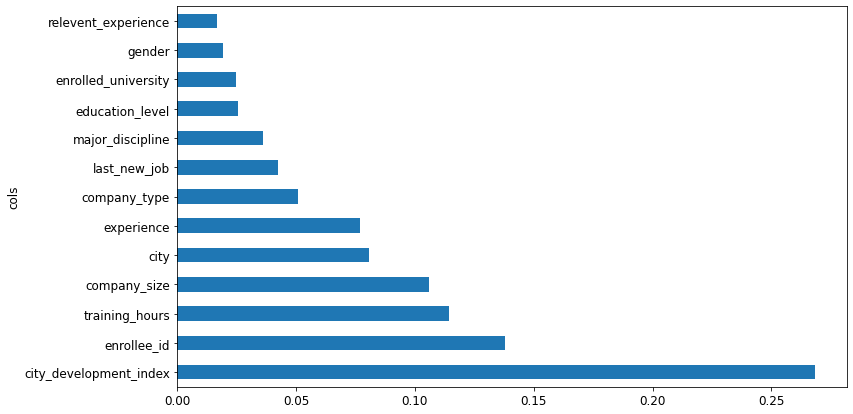

In [121]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

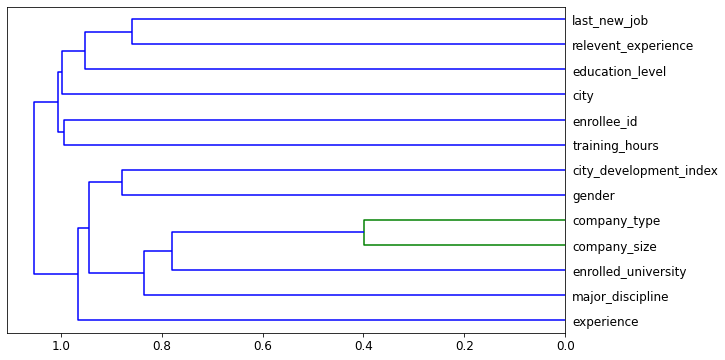

In [129]:
cluster_columns(xs)

In [130]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=5000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [131]:
get_oob(xs)

0.2590449582762169

In [149]:
{c:get_oob(xs.drop(c, axis=1)) for c in (
    'relevent_experience', 'gender', 'enrolled_university','education_level',
    'major_discipline', 'last_new_job',
    'company_type','experience', 'city')}

{'city': 0.2608831189014752,
 'company_type': 0.25737661115881394,
 'education_level': 0.26006767974987877,
 'enrolled_university': 0.25979785933990474,
 'experience': 0.2605324534741664,
 'gender': 0.26105578962649933,
 'last_new_job': 0.25949612513691034,
 'major_discipline': 0.25692670958424546,
 'relevent_experience': 0.2607888988393854}

In [210]:
to_drop = [ 'gender', 'enrolled_university', 'company_type']
get_oob(xs.drop(to_drop, axis=1))

0.2565448665650326

In [211]:
xs_final = xs.drop(to_drop, axis=1)
valid_xs_final = valid_xs.drop(to_drop, axis=1)

In [212]:
m = rf(xs_final, y)
roc_auc_score(y.to_numpy(), m.predict(xs_final)), roc_auc_score(valid_y.to_numpy(), m.predict(valid_xs_final))

(0.9389479762974925, 0.7789716343297575)

In [213]:
cont_nn,cat_nn = cont_cat_split(train_ds, max_card=9000, dep_var=dep_var)

cat_nn.remove('gender')
cat_nn.remove('enrolled_university')
cat_nn.remove('company_type')


## Test Again

In [214]:
tabular_data = TabularPandas(train_ds, 
                      procs, 
                      cat_nn, 
                      cont_nn,
                      splits=RandomSplitter(valid_pct=0.2)(range_of(train_ds)), 
                      y_names=dep_var,
                      y_block = CategoryBlock )

dls = tabular_data.dataloaders(256)
learn = tabular_learner(dls,
                        metrics=[accuracy, RocAucBinary()])

SuggestedLRs(valley=0.0010000000474974513)

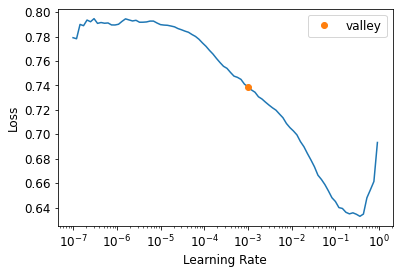

In [215]:
learn.lr_find()

In [216]:
learn.fit_one_cycle(2, 3e-2, wd=0.1)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.495596,0.469788,0.771339,0.777890,00:01
1,0.451735,0.436702,0.794310,0.801153,00:01


SuggestedLRs(valley=3.981071586167673e-06)

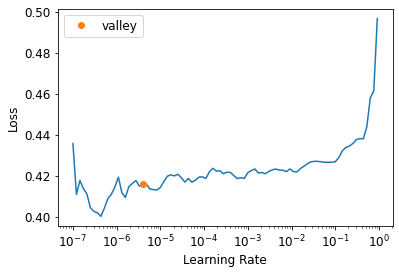

In [217]:
learn.lr_find()

The ROC AUC score improves by a bit

## Prediction

In [220]:
test_dl = learn.dls.test_dl(test_ds)
predictions = learn.get_preds(dl=test_dl)

In [221]:
predictions, predictions[0][:,1]

((tensor([[0.9446, 0.0554],
          [0.4233, 0.5767],
          [0.4182, 0.5818],
          ...,
          [0.8254, 0.1746],
          [0.9218, 0.0782],
          [0.9508, 0.0492]]), None),
 tensor([0.0554, 0.5767, 0.5818,  ..., 0.1746, 0.0782, 0.0492]))

In [222]:
result = pd.DataFrame({'enrollee_id': test_ds['enrollee_id'], 'target': predictions[0][:,1]})
result.to_csv('result.csv')